# Replication code for the following paper: 
### `"Causal Impact of Android Go on Mobile Web Performance", ACM Internet Measurement Conference (IMC), October 25-27, 2022, Nice, France`
- Project Team: [Dr. Ihsan Ayyub Qazi (LUMS)](https://www.ihsanqazi.com), [Dr. Zafar Ayyub Qazi (LUMS)](https://web.lums.edu.pk/~zafar/), and Muhammad Abdullah (LUMS)
- Contact: For any questions or feedback, please contact Ihsan Ayyub Qazi (ihsan.qazi@lums.edu.pk)
- [ACM IMC 2022 Website]([link](https://conferences.sigcomm.org/imc/2022/accepted/))


---
**This notebook contains the following analyses as well as code for generating paper plots. The generated plots are saved in the "figs" folder locally.**
- **Impact of the Operating System (Android Go vs. non-Go)**
    * Outcome variables: Time-To-First-Byte (TTFB), Page Load Time (PLT), and Crash Rate

- **Heterogeneous Treatment Effects Analysis (i.e., _impact of Android Go across difference memory pressure states_)**
    * No-MP: Normal memory pressure state
    * Low-MP: Low memory pressure state
    * High-MP: High memory pressure state

- **Impact of Webpage Characteristics on PLT across Go & non-Go** (e.g., scripts, JS, images, fonts, iframes)
    * Using Random Forest (RF) to find most predictive features of PLT

**Approaches/Methods used the study**
- Controlled Experiments
- Difference-in-means Estimates
- OLS regression (w/ and w/o interaction terms)
- Heckman selection model (w/ and w/o interaction terms) --> see the accompanying R file `"public_imc22_replicationCode.rmd"` for replication of results involving the Heckman selection model as well as generating Appendix Table 8
- Random forest (RF) regression
---
Other Notes
- Non-Go is the same as GSI (Generic System Image)

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');
import torch
from sklearn.linear_model import LinearRegression
from scipy import stats
import econtools

## The Data
This dataset contains data on page loads of Alexa top 100 pages over Android Go and Non-Go versions using the same entry-level smartphone (Nokia 1). Each row in the dataset corresponds to the average page load metrics (e.g., TTFB and PLT) for 10 runs along with information about the loaded Web pages and its various features (represented as seperate columns.

In addition, page loads were carried out under different device memory pressure (MP) states; no MP, low MP, and high MP. The resulting dataset contains $N=600$ data samples, which are used for carrying out the primary analysis of the paper.

For evaluation involving different Android Go versions and different mobile devices, we conducted additional measurements, which were saved in seperate CSV files and whose analysis is also reported in this notebook.

## Finding the Causal Impact of Android Go

Our goal is to find the causal impact of Go on different outcomes (TTFB, PLT, and page crash rate) relative to non-Go versions of Android. To this end, we compute various estimates of the causal impact, which includes:
1. Difference-in-means estimate
2. OLS regression estimates with and without Web page features as control variables
3. Heckman selection model to correct for selection bias introduced due to missing data resulting from page crashes (see the accompanying R file `"public_imc22_replicationCode.rmd"` for replicating results involving the Heckman selection model).

In addition, we also conduct heterogeneous treatment effects analysis using the above approaches to analyze how the causal impact varies across different MP states.

In [100]:
# Clean data
# 1. Remove alipay.com and jd.com (these pages did not load under both Go and No-MP even without any memory pressure, possibly due to blocking of these pages)
# 2. If PLT value is 'E', convert to 0 (0 indicate that the page crashed)
# 3. Convert the entire PLT column to be of type float

data = pd.read_csv("imc22_dataset.csv")

# Step-1
drop_index = data.loc[data["URL"] == "https://www.alipay.com"].index
data.drop(drop_index, axis=0, inplace=True)
drop_index = data.loc[data["URL"] == "https://www.jd.com"].index
data.drop(drop_index, axis=0, inplace=True)
print("N (observations) =",data.count()[1])

# Step-2
## if PLT == E or 0, set crash=1 otherwise 0
data['crash'] = np.where((data['PLT']=='E') | (data['PLT']=='0'), 1, 0)
## if PLT == E, change to 0
data['PLT'] = data['PLT'].replace('E',0)

# Step-3
## convert to float
data['PLT'] = data['PLT'].astype(float)

data.loc[data["crash"]==1].sample(5)

N (observations) = 588


,id,URL,os,mp_no,mp_low,mp_high,pagesize_kb,num_requests,num_scripts,scripts_kb,...,num_css,css_kb,dom_elements,iframes_kb,num_iframes,fonts_kb,requests_font,PLT,TTFB,crash
486,487,https://www.arcgis.com,0,0,0,1,1418.32,44,13,1001.1152,...,5,135.189453,285,3.405273,5,56.833008,3,0.0,8150.3,1
487,488,https://www.nih.gov,0,0,0,1,520.07,53,14,239.4287,...,10,35.793945,844,15.301758,3,24.476562,3,0.0,3656.4,1
455,456,https://www.imdb.com,0,0,0,1,1834.56,99,38,854.0947,...,4,40.391602,3996,164.497070,6,32.281250,3,0.0,1892.9,1
290,291,https://www.paypal.com,0,0,1,0,3590.35,45,16,443.4805,...,1,49.665039,380,27.095703,6,35.820312,2,0.0,864.9,1
460,461,https://www.instructure.com,0,0,0,1,1667.58,107,54,1254.3770,...,8,61.076172,1400,54.578125,9,168.812500,7,0.0,1340.9,1


## <font color=blue>A. Time to First Byte (TTFB) Analysis</font>
`Mean with CI plots + OLS Regression Analysis`

### (i) Mean Difference in TTFB (Go vs. Non-Go AND across different MP states)
- The treatment (Andriod Go) and control (Non-Go) groups are perfectly balanced because we are able to obtain TTFB values for all webpages

In [101]:
# overall difference in means
diff = data.loc[data['os'] == 1]["TTFB"].mean() - data.loc[data['os'] == 0]["TTFB"].mean()
diff_mp_no = data.loc[(data['os'] == 1) & (data['mp_no'] == 1)]["TTFB"].mean() - data.loc[(data['os'] == 0) & (data['mp_no'] == 1)]["TTFB"].mean()
diff_mp_low = data.loc[(data['os'] == 1) & (data['mp_low'] == 1)]["TTFB"].mean() - data.loc[(data['os'] == 0) & (data['mp_low'] == 1)]["TTFB"].mean()
diff_mp_high = data.loc[(data['os'] == 1) & (data['mp_high'] == 1)]["TTFB"].mean() - data.loc[(data['os'] == 0) & (data['mp_high'] == 1)]["TTFB"].mean()

print("Non-Go TTFB mean =", data.loc[data['os'] == 0]["TTFB"].mean(), "std=", np.sqrt(data.loc[data['os'] == 0]["TTFB"].std()))
print("Go TTFB     mean =", data.loc[data['os'] == 1]["TTFB"].mean(), "std=", np.sqrt(data.loc[data['os'] == 1]["TTFB"].std()))
print("TTFB", stats.ttest_ind(a=data.loc[data['os'] == 1]["TTFB"], b=data.loc[data['os'] == 0]["TTFB"], alternative='two-sided'))

print("\nMean difference in TTFB (i.e., GSI-Go) = ", round(diff,1), "ms")
print("% Improvement in TTFB over non-Go: ", (data.loc[data['os'] == 0]["TTFB"].mean() - data.loc[data['os'] == 1]["TTFB"].mean()) * 100.0 / data.loc[data['os'] == 0]["TTFB"].mean(), "%")

print("\nMean difference in TTFB under No MP = ", round(diff_mp_no,1), "ms")
print("Mean difference in TTFB under Low MP = ", round(diff_mp_low,1), "ms")
print("Mean difference in TTFB under High MP = ", round(diff_mp_high,1), "ms")

Non-Go TTFB mean = 1785.557482993197 std= 51.22504496922532
Go TTFB     mean = 902.9783014789114 std= 19.550562766967822
TTFB Ttest_indResult(statistic=-5.706941011765529, pvalue=1.8278110385299573e-08)

Mean difference in TTFB (i.e., GSI-Go) =  -882.6 ms
% Improvement in TTFB over non-Go:  49.42877448194976 %

Mean difference in TTFB under No MP =  -29.7 ms
Mean difference in TTFB under Low MP =  -693.3 ms
Mean difference in TTFB under High MP =  -1924.7 ms


## `Figure 6a`

[Go]      : 0.9 +- 0.04 CI
[Non-Go]  : 1.79 +- 0.3 CI


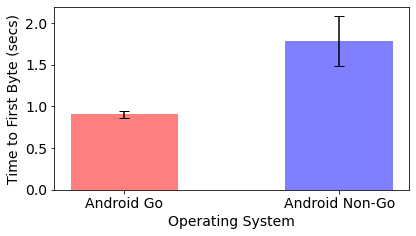

In [114]:
plt.rcParams.update({'font.size': 14})

list_ttfb = []

temp1 = data.loc[(data['os'] == 1)]["TTFB"]
temp1.reset_index(drop=True, inplace=True)
t1_mean = temp1.mean()/1000
list_ttfb.append(t1_mean)

temp2 = data.loc[(data['os'] == 0)]["TTFB"]
temp2.reset_index(drop=True, inplace=True)
t2_mean = temp2.mean()/1000
list_ttfb.append(t2_mean)

list_s = []
s1=(t1_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp1/1000), scale=stats.sem(temp1/1000))[0]
list_s.append(s1)
s2=(t2_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp2/1000), scale=stats.sem(temp2/1000))[0]
list_s.append(s2)

print("[Go]      :", round(t1_mean,2), "+-", round(s1,2), "CI")
print("[Non-Go]  :", round(t2_mean,2), "+-", round(s2,2), "CI")

#---------------------------------------------------------------------------

# initialise data of lists.
usable = {'os':['Android Go','Android Non-Go'],
        'ttfb':list_ttfb,
         'ci':list_s}

usable = pd.DataFrame(usable)
 
new_colors = ['red','blue']
        
plt.figure(figsize=(6,3.5))
plt.bar(usable['os'],usable['ttfb'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)

plt.xlabel('Operating System')
plt.ylabel('Time to First Byte (secs)')
#plt.legend()
plt.tight_layout()
plt.savefig('figs/ttfb_go_vs_gsi.png', dpi=400)
plt.show()

In [115]:
ttfb_list = []

temp1 = data.loc[(data['os'] == 1) & (data['mp_no'] == 1)]["TTFB"]
temp1.reset_index(drop=True, inplace=True)
t1_mean = temp1.mean()
ttfb_list.append(t1_mean/1000)

temp2 = data.loc[(data['os'] == 0) & (data['mp_no'] == 1)]["TTFB"]
temp2.reset_index(drop=True, inplace=True)
t2_mean = temp2.mean()
ttfb_list.append(t2_mean/1000)

temp3 = data.loc[(data['os'] == 1) & (data['mp_low'] == 1)]["TTFB"]
temp3.reset_index(drop=True, inplace=True)
t3_mean = temp3.mean()
ttfb_list.append(t3_mean/1000)

temp4 = data.loc[(data['os'] == 0) & (data['mp_low'] == 1)]["TTFB"]
temp4.reset_index(drop=True, inplace=True)
t4_mean = temp4.mean()
ttfb_list.append(t4_mean/1000)

temp5 = data.loc[(data['os'] == 1) & (data['mp_high'] == 1)]["TTFB"]
temp5.reset_index(drop=True, inplace=True)
t5_mean = temp5.mean()
ttfb_list.append(t5_mean/1000)

temp6 = data.loc[(data['os'] == 0) & (data['mp_high'] == 1)]["TTFB"]
temp6.reset_index(drop=True, inplace=True)
t6_mean = temp6.mean()
ttfb_list.append(t6_mean/1000)

# Finding 1-sided CI values
s_list = []
s1=(t1_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1))[0]
s_list.append(s1/1000)
s2=(t2_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2))[0]
s_list.append(s2/1000)
s3=(t3_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp3), scale=stats.sem(temp3))[0]
s_list.append(s3/1000)
s4=(t4_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp4), scale=stats.sem(temp4))[0]
s_list.append(s4/1000)
s5=(t5_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp5), scale=stats.sem(temp5))[0]
s_list.append(s5/1000)
s6=(t6_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp6), scale=stats.sem(temp6))[0]
s_list.append(s6/1000)

## `Figure 8b`

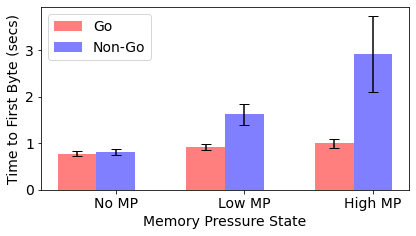

In [116]:
plt.rcParams.update({'font.size': 14})

usable = {'os':['(Go, No-MP)', '(Non-Go, No-MP)', '(Go, Low-MP)', '(Non-Go, Low-MP)', '(Go, High-MP)', '(Non-Go, High-MP)'],
        'ttfb': ttfb_list,
         'ci': s_list}

usable1 = {'os':['(Go, No-MP)', '(Go, Low-MP)', '(Go, High-MP)'],
        'ttfb': [t1_mean/1000, t3_mean/1000, t5_mean/1000],
         'ci': [s1/1000, s3/1000, s5/1000]}

usable2 = {'os':['(Non-Go, No-MP)', '(Non-Go, Low-MP)', '(Non-Go, High-MP)'],
        'ttfb': [t2_mean/1000, t4_mean/1000, t6_mean/1000],
         'ci': [s2/1000, s4/1000, s6/1000]}

usable = pd.DataFrame(usable)
 
new_colors2 = ['blue','blue','blue']
new_colors1 = ['red','red','red']

barWidth = 0.3
r1 = np.arange(len(usable1))
r2 = [x + barWidth for x in r1]
    
plt.figure(figsize=(6,3.5))
plt.bar(r1, usable1['ttfb'], width = barWidth, yerr=usable1['ci'],color=new_colors1,alpha=0.5, align='center',capsize=5,label='Go')
plt.bar(r2, usable2['ttfb'], width = barWidth, yerr=usable2['ci'],color=new_colors2,alpha=0.5, align='center',capsize=5,label='Non-Go')

plt.xticks([r + barWidth for r in range(len(usable1))], ['No MP', 'Low MP', 'High MP'])
plt.ylabel('height')
plt.legend()

plt.xlabel('Memory Pressure State')
plt.ylabel('Time to First Byte (secs)')
plt.tight_layout()
plt.savefig('figs/ttfb_mp.png', dpi=400)
plt.show()

### (iii) OLS Regression Analysis

In [126]:
# specification-1: We regress os on TTFB to find the causal effect of os.
formula = 'TTFB ~ os'
model = smf.ols(formula, data=data)
## for analyzing the TTFB of crashed pages only, uncomment the line below
## model = smf.ols(formula, data=data.loc[data['PLT'] == 0])
results = model.fit()
print(results.summary())
## print(results.pvalues)

                            OLS Regression Results                            
Dep. Variable:                   TTFB   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     32.57
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           1.83e-08
Time:                        23:37:30   Log-Likelihood:                -5264.7
No. Observations:                 588   AIC:                         1.053e+04
Df Residuals:                     586   BIC:                         1.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1785.5575    109.354     16.328      0.0

In [19]:
## specification-2: with interaction effects
formula = 'TTFB ~ os + mp_low + mp_high + os:mp_low + os:mp_high'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())
#print(results.params)

print("\n")
print("TTFB in the Control (GSI)         = ", round(results.params[0],1), "ms")
print("Causal Impact of Go under No MP   = ", round(results.params[1],1), "ms")
print("Causal Impact of Go under Low MP  = ", round(results.params[1] + results.params[4], 1), "ms")
print("Causal Impact of Go under High MP = ", round(results.params[1] + results.params[5], 1), "ms")

                            OLS Regression Results                            
Dep. Variable:                   TTFB   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     21.60
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           7.40e-20
Time:                        12:16:33   Log-Likelihood:                -5230.6
No. Observations:                 588   AIC:                         1.047e+04
Df Residuals:                     582   BIC:                         1.050e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    809.6367    179.337      4.515      0.0

---

## <font color=blue>B. Page Load Time (PLT) Analysis</font>
`- Mean with CI plots + OLS Regression Analysis`

### Data Cleaning
1. Clean data by excluding the two Web pages that did not load correctly possibly due to blocking (alipay.com and jd.com)
2. Introduce a new column 'crash' representing a binary feature (1 if the page crashed, 0 otherwise)


In [127]:
df_plt = pd.read_csv("imc22_dataset.csv")
df_orig = pd.read_csv("imc22_dataset.csv")

# Step-1
drop_index = df_plt.loc[df_plt["URL"] == "https://www.alipay.com"].index
df_plt.drop(drop_index, axis=0, inplace=True)
drop_index = df_plt.loc[df_plt["URL"] == "https://www.jd.com"].index
df_plt.drop(drop_index, axis=0, inplace=True)

drop_index = df_orig.loc[df_orig["URL"] == "https://www.alipay.com"].index
df_orig.drop(drop_index, axis=0, inplace=True)
drop_index = df_orig.loc[df_orig["URL"] == "https://www.jd.com"].index
df_orig.drop(drop_index, axis=0, inplace=True)

# Step-2
## if PLT == E or 0, set crash=1 otherwise 0
df_plt['crash'] = np.where((df_plt['PLT']=='E') | (df_plt['PLT']=='0'), 1, 0)
df_orig['crash'] = np.where((df_orig['PLT']=='E') | (df_orig['PLT']=='0'), 1, 0)

## if PLT == E, change to 0
df_plt['PLT'] = df_plt['PLT'].replace('E',0)
df_orig['PLT'] = df_orig['PLT'].replace('E',0)

# Step-3
## convert to float
df_plt['PLT'] = df_plt['PLT'].astype(float)
df_orig['PLT'] = df_orig['PLT'].astype(float)

go_succ_pages = df_plt.loc[ (df_plt['os']==1) & (df_plt['crash']==0)]
nongo_succ_pages = df_plt.loc[ (df_plt['os']==0) & (df_plt['crash']==0)]

### Balance Checks

In [131]:
print("Pages loaded successfully in Go     :", len(go_succ_pages))
print("Pages loaded successfully in non-Go :", len(nongo_succ_pages))

Pages loaded successfully in Go     : 291
Pages loaded successfully in non-Go : 258


In [132]:
from scipy.stats import sem

print("Non-Go -- (pagesize kb) mean=", nongo_succ_pages['pagesize_kb'].mean(), ", sem=", sem(nongo_succ_pages['pagesize_kb'] ))
print("Go     -- (pagesize kb) mean=", go_succ_pages['pagesize_kb'].mean(), ", sem=", sem(go_succ_pages['pagesize_kb'] ))
print("(pagesize kb)      mean diff=", go_succ_pages['pagesize_kb'].mean()-nongo_succ_pages['pagesize_kb'].mean())

print("\nNon-Go -- (dom nodes) mean=", nongo_succ_pages['dom_elements'].mean(), ", sem=", sem(nongo_succ_pages['dom_elements'] ))
print("Go     -- (dom nodes) mean=", go_succ_pages['dom_elements'].mean(), ", sem=", sem(go_succ_pages['dom_elements'] ))
print("(dom_elements)   mean diff=", go_succ_pages['dom_elements'].mean()-nongo_succ_pages['dom_elements'].mean())

print("\nNon-Go -- (scripts kb) mean=", nongo_succ_pages['scripts_kb'].mean(), ", sem=", sem(nongo_succ_pages['scripts_kb'] ))
print("Go     -- (scripts kb) mean=", go_succ_pages['scripts_kb'].mean(), ", sem=", sem(go_succ_pages['scripts_kb'] ))
print("(scripts_kb)   mean diff=", go_succ_pages['scripts_kb'].mean()-nongo_succ_pages['scripts_kb'].mean())

print("\nNon-Go -- (image kb) mean=", nongo_succ_pages['images_kb'].mean(), ", sem=", sem(nongo_succ_pages['images_kb'] ))
print("Go     -- (image kb) mean=", go_succ_pages['images_kb'].mean(), ", sem=", sem(go_succ_pages['images_kb'] ))
print("(images_kb)   mean diff=", go_succ_pages['images_kb'].mean()-nongo_succ_pages['images_kb'].mean())

print("\nNon-Go -- (css kb) mean=", nongo_succ_pages['css_kb'].mean(), ", sem=", sem(nongo_succ_pages['css_kb'] ))
print("Go     -- (css kb) mean=", go_succ_pages['css_kb'].mean(), ", sem=", sem(go_succ_pages['css_kb'] ))
print("(css_kb)   mean diff=", go_succ_pages['css_kb'].mean()-nongo_succ_pages['css_kb'].mean())

print("\nNon-Go -- (iframe kb) mean=", nongo_succ_pages['iframes_kb'].mean(), ", sem=", sem(nongo_succ_pages['iframes_kb'] ))
print("Go     -- (iframe kb) mean=", go_succ_pages['iframes_kb'].mean(), ", sem=", sem(go_succ_pages['iframes_kb'] ))
print("(iframes_kb)   mean diff=", go_succ_pages['iframes_kb'].mean()-nongo_succ_pages['iframes_kb'].mean())

print("\nNon-Go -- (fonts kb) mean=", nongo_succ_pages['fonts_kb'].mean(), ", sem=", sem(nongo_succ_pages['fonts_kb'] ))
print("Go     -- (fonts kb) mean=", go_succ_pages['fonts_kb'].mean(), ", sem=", sem(go_succ_pages['fonts_kb'] ))
print("(fonts_kb)   mean diff=", go_succ_pages['fonts_kb'].mean()-nongo_succ_pages['fonts_kb'].mean())

################

print("\n--------------------\n")
print("Non-Go -- (objects) mean=", nongo_succ_pages['num_requests'].mean(), ", sem=", sem(nongo_succ_pages['num_requests'] ))
print("Go     -- (objects) mean=", go_succ_pages['num_requests'].mean(), ", sem=", sem(go_succ_pages['num_requests'] ))
print("(objects)   mean diff=", go_succ_pages['num_requests'].mean()-nongo_succ_pages['num_requests'].mean())

print("\nNon-Go -- (scripts) mean=", nongo_succ_pages['num_scripts'].mean(), ", sem=", sem(nongo_succ_pages['num_scripts'] ))
print("Go     -- (scripts) mean=", go_succ_pages['num_scripts'].mean(), ", sem=", sem(go_succ_pages['num_scripts'] ))
print("(num_scripts)  mean diff=", go_succ_pages['num_scripts'].mean()-nongo_succ_pages['num_scripts'].mean())

print("\nNon-Go -- (images) mean=", nongo_succ_pages['num_images'].mean(), ", sem=", sem(nongo_succ_pages['num_images'] ))
print("Go     -- (images) mean=", go_succ_pages['num_images'].mean(), ", sem=", sem(go_succ_pages['num_images'] ))
print("(num_images)  mean diff=", go_succ_pages['num_images'].mean()-nongo_succ_pages['num_images'].mean())

print("\nNon-Go -- (css) mean=", nongo_succ_pages['num_css'].mean(), ", sem=", sem(nongo_succ_pages['num_css'] ))
print("Go     -- (css) mean=", go_succ_pages['num_css'].mean(), ", sem=", sem(go_succ_pages['num_css'] ))
print("(num_css)  mean diff=", go_succ_pages['num_css'].mean()-nongo_succ_pages['num_css'].mean())

print("\nNon-Go -- (iframe) mean=", nongo_succ_pages['num_iframes'].mean(), ", sem=", sem(nongo_succ_pages['num_iframes'] ))
print("Go     -- (iframe) mean=", go_succ_pages['num_iframes'].mean(), ", sem=", sem(go_succ_pages['num_iframes'] ))
print("(num_iframes)  mean diff=", go_succ_pages['num_iframes'].mean()-nongo_succ_pages['num_iframes'].mean())

print("\nNon-Go -- (fonts kb) mean=", nongo_succ_pages['requests_font'].mean(), ", sem=", sem(nongo_succ_pages['requests_font'] ))
print("Go     -- (fonts kb) mean=", go_succ_pages['requests_font'].mean(), ", sem=", sem(go_succ_pages['requests_font'] ))
print("(requests_font)  mean diff=", go_succ_pages['requests_font'].mean()-nongo_succ_pages['requests_font'].mean())

print("\n--------------------\n")

print("\nNon-Go -- TTFB mean=", nongo_succ_pages['TTFB'].mean(), ", sem=", sem(nongo_succ_pages['TTFB'] ))
print("Go     -- TTFB mean=", go_succ_pages['TTFB'].mean(), ", sem=", sem(go_succ_pages['TTFB'] ))
print("(TTFB)  mean diff=", go_succ_pages['TTFB'].mean()-nongo_succ_pages['TTFB'].mean())

print("\nNon-Go -- PLT mean=", nongo_succ_pages['PLT'].mean(), ", sem=", sem(nongo_succ_pages['PLT'] ))
print("Go     -- PLT mean=", go_succ_pages['PLT'].mean(), ", sem=", sem(go_succ_pages['PLT'] ))
print("(PLT)  mean diff=", go_succ_pages['PLT'].mean()-nongo_succ_pages['PLT'].mean())

print("% Reduction in PLT over non-Go=", (nongo_succ_pages['PLT'].mean() - go_succ_pages['PLT'].mean()) * 100.0 / nongo_succ_pages['PLT'].mean()) 




Non-Go -- (pagesize kb) mean= 1278.2730232558142 , sem= 66.1515819551011
Go     -- (pagesize kb) mean= 1335.3094501718217 , sem= 65.14924246511116
(pagesize kb)      mean diff= 57.036426916007485

Non-Go -- (dom nodes) mean= 1112.0658914728683 , sem= 80.52048956373665
Go     -- (dom nodes) mean= 1175.4948453608247 , sem= 75.71979944970312
(dom_elements)   mean diff= 63.42895388795637

Non-Go -- (scripts kb) mean= 643.3075182170543 , sem= 37.71398414749533
Go     -- (scripts kb) mean= 679.9924835051545 , sem= 36.24416081003396
(scripts_kb)   mean diff= 36.684965288100216

Non-Go -- (image kb) mean= 628.8669944772442 , sem= 52.34697369637841
Go     -- (image kb) mean= 650.627956549962 , sem= 50.884716829289985
(images_kb)   mean diff= 21.760962072717803

Non-Go -- (css kb) mean= 54.81695130862021 , sem= 4.060176284385664
Go     -- (css kb) mean= 58.15201151856707 , sem= 4.087987901132057
(css_kb)   mean diff= 3.3350602099468603

Non-Go -- (iframe kb) mean= 71.67546330234103 , sem= 7.5122

In [134]:
import scipy.stats as stats

#stats.ttest_ind(a=go_succ_pages['pagesize_kb'], b=nongo_succ_pages['pagesize_kb'], alternative='two-sided')
#stats.ttest_ind(a=go_succ_pages['dom_elements'], b=nongo_succ_pages['dom_elements'], alternative='two-sided')

#stats.ttest_ind(a=go_succ_pages['scripts_kb'], b=nongo_succ_pages['scripts_kb'], alternative='two-sided')
#stats.ttest_ind(a=go_succ_pages['images_kb'], b=nongo_succ_pages['images_kb'], alternative='two-sided')
#stats.ttest_ind(a=go_succ_pages['css_kb'], b=nongo_succ_pages['css_kb'], alternative='two-sided')
#stats.ttest_ind(a=go_succ_pages['iframes_kb'], b=nongo_succ_pages['iframes_kb'], alternative='two-sided')
#stats.ttest_ind(a=go_succ_pages['fonts_kb'], b=nongo_succ_pages['fonts_kb'], alternative='two-sided')

print("num_requests", stats.ttest_ind(a=go_succ_pages['num_requests'], b=nongo_succ_pages['num_requests'], alternative='two-sided', equal_var=True))
print("num_scripts", stats.ttest_ind(a=go_succ_pages['num_scripts'], b=nongo_succ_pages['num_scripts'], alternative='two-sided', equal_var=True))
print("num_images", stats.ttest_ind(a=go_succ_pages['num_images'], b=nongo_succ_pages['num_images'], alternative='two-sided', equal_var=True))
print("num_css", stats.ttest_ind(a=go_succ_pages['num_css'], b=nongo_succ_pages['num_css'], alternative='two-sided', equal_var=True))
print("num_iframes", stats.ttest_ind(a=go_succ_pages['num_iframes'], b=nongo_succ_pages['num_iframes'], alternative='two-sided', equal_var=True))
print("requests_font", stats.ttest_ind(a=go_succ_pages['requests_font'], b=nongo_succ_pages['requests_font'], alternative='two-sided', equal_var=True))

print("\nPLT mean diff", stats.ttest_ind(a=go_succ_pages['PLT'], b=nongo_succ_pages['PLT'], alternative='two-sided', equal_var=False))
print("TTFB mean diff", stats.ttest_ind(a=go_succ_pages['TTFB'], b=nongo_succ_pages['TTFB'], alternative='two-sided', equal_var=False))

num_requests Ttest_indResult(statistic=0.5475561580130383, pvalue=0.5842200422102524)
num_scripts Ttest_indResult(statistic=0.29017041726976034, pvalue=0.7717958343639029)
num_images Ttest_indResult(statistic=0.41770990505724326, pvalue=0.676323141433989)
num_css Ttest_indResult(statistic=-0.03020696025488583, pvalue=0.9759130154689051)
num_iframes Ttest_indResult(statistic=0.6005026723096659, pvalue=0.5484199940681846)
requests_font Ttest_indResult(statistic=0.043484042741048584, pvalue=0.965331552932267)

PLT mean diff Ttest_indResult(statistic=-4.6586828049338616, pvalue=4.298502257793522e-06)
TTFB mean diff Ttest_indResult(statistic=-3.9043710842941435, pvalue=0.00011955065096033898)


## `Figure 5`

[Non-Go (succ)]      : 1.49 +- 0.29 CI
[Non-Go (all)]  : 1.79 +- 0.3 CI


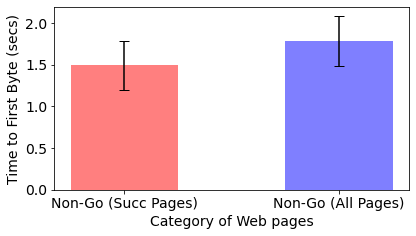

In [139]:
plt.rcParams.update({'font.size': 14})

list_ttfb = []
temp1 = nongo_succ_pages["TTFB"]
temp1.reset_index(drop=True, inplace=True)
t1_mean = temp1.mean()/1000
list_ttfb.append(t1_mean)

temp2 = df_plt.loc[(df_plt['os'] == 0)]["TTFB"]
temp2.reset_index(drop=True, inplace=True)
t2_mean = temp2.mean()/1000
list_ttfb.append(t2_mean)

list_s = []
s1=(t1_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp1/1000), scale=stats.sem(temp1/1000))[0]
list_s.append(s1)
s2=(t2_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp2/1000), scale=stats.sem(temp2/1000))[0]
list_s.append(s2)

print("[Non-Go (succ)]      :", round(t1_mean,2), "+-", round(s1,2), "CI")
print("[Non-Go (all)]  :", round(t2_mean,2), "+-", round(s2,2), "CI")

## ---------------------------------------------------------------------------
usable = {'os':['Non-Go (Succ Pages)','Non-Go (All Pages)'],
        'ttfb':list_ttfb,
         'ci':list_s}

usable = pd.DataFrame(usable)
 
new_colors = ['red','blue']
        
plt.figure(figsize=(6,3.5))
plt.bar(usable['os'],usable['ttfb'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)

plt.xlabel('Category of Web pages')
plt.ylabel('Time to First Byte (secs)')
plt.tight_layout()
plt.savefig('figs/ttfb_nongo_succ_vs_all.png', dpi=400)
plt.show()

### Crash Rate Analysis

In [140]:
df_crash = df_orig.loc[df_orig['PLT'] == 0]
df_succ = df_orig.loc[df_orig['PLT'] != 0]

print("Total successful page loads in GSI:",len(df_succ.loc[(df_plt['os'] == 0)]))
print("Total successful page loads in Go:",len(df_succ.loc[(df_plt['os'] == 1)]))
print("Total successful page loads:", len(df_succ), "\n")
     
print("Total pages crashed in GSI:", len(df_crash.loc[(df_crash['os'] == 0)]))
print("Total pages crashed in Go:", len(df_crash.loc[(df_crash['os'] == 1)]))
print("Total pages crashed:", len(df_crash), "\n")

print("Total pages crashed in GSI:", 100 * len(df_crash.loc[(df_crash['os'] == 0)])/(len(df_orig) * 0.5))
print("Total pages crashed in Go:", 100 * len(df_crash.loc[(df_crash['os'] == 1)])/(len(df_orig) * 0.5))
print("Total crash rate", round(100 * len(df_crash)/len(df_orig), 2), "%")

Total successful page loads in GSI: 258
Total successful page loads in Go: 291
Total successful page loads: 549 

Total pages crashed in GSI: 36
Total pages crashed in Go: 3
Total pages crashed: 39 

Total pages crashed in GSI: 12.244897959183673
Total pages crashed in Go: 1.0204081632653061
Total crash rate 6.63 %


## `Figure 4a`

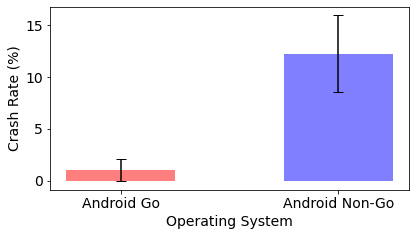

In [142]:
plt.rcParams.update({'font.size': 14})

usable = {'os':['Android Go','Android Non-Go'],
        'plt':[1.02, 12.24],
         'ci':[1.1, 3.7]}

usable = pd.DataFrame(usable)
new_colors = ['red','blue']

plt.figure(figsize=(6,3.5))
plt.bar(usable['os'],usable['plt'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)
plt.xlabel('Operating System')
plt.ylabel('Crash Rate (%)')
plt.tight_layout()
plt.savefig('figs/plt_go_vs_gsi_crashrate.png', dpi=400)
plt.show()

In [145]:
# print("Total pages crashed in GSI -- No-MP:", 100 * len(df_crash.loc[ (df_crash['os']==0) & (df_crash['mp_no']==1) ]) / (len(df_orig)/6) )
# print("Total pages crashed in GSI -- Low-MP:", 100 * len(df_crash.loc[ (df_crash['os']==0) & (df_crash['mp_low']==1) ]) / (len(df_orig)/6) )
# print("Total pages crashed in GSI -- High-MP:", 100 * len(df_crash.loc[ (df_crash['os']==0) & (df_crash['mp_high']==1) ]) / (len(df_orig)/6) )
# print("Total pages crashed in GSI -- High-MP:", len(df_crash.loc[ (df_crash['os']==0) & (df_crash['mp_high']==1) ]) )

# print("Total pages crashed in Go -- No-MP:", 100 * len(df_crash.loc[ (df_crash['os']==1) & (df_crash['mp_no']==1) ]) / (len(df_orig)/6) )
# print("Total pages crashed in Go -- Low-MP:", 100 * len(df_crash.loc[ (df_crash['os']==1) & (df_crash['mp_low']==1) ]) / (len(df_orig)/6) )
# print("Total pages crashed in Go -- High-MP:", 100 * len(df_crash.loc[ (df_crash['os']==1) & (df_crash['mp_high']==1) ]) / (len(df_orig)/6) )
# print("Total pages crashed in Go -- High-MP:", len(df_crash.loc[ (df_crash['os']==1) & (df_crash['mp_high']==1) ]) )

# print("% Reduction:", (4.08-0.34) * 100/ 4.08)
# print(len(df_orig))

## `Figure 8a`

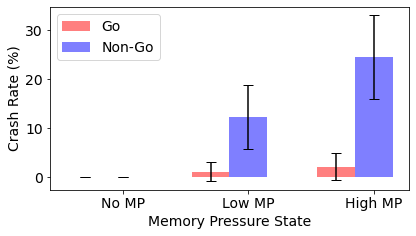

In [149]:
plt.rcParams.update({'font.size': 14})

usable1 = {'os':['(Go, No-MP)', '(Go, Low-MP)', '(Go, High-MP)'],
        'plt': [0, 1.020, 2.041],
         'ci': [0, 1.97, 2.77]}

usable2 = {'os':['(Non-Go, No-MP)', '(Non-Go, Low-MP)', '(Non-Go, High-MP)'],
        'plt': [0, 12.24, 24.49],
         'ci': [0, 6.48, 8.52]}

usable = pd.DataFrame(usable)
new_colors2 = ['blue','blue','blue']
new_colors1 = ['red','red','red']

barWidth = 0.3
r1 = np.arange(len(usable1))
r2 = [x + barWidth for x in r1]
    
plt.figure(figsize=(6,3.5))
plt.bar(r1, usable1['plt'], yerr=usable1['ci'], width = barWidth, color=new_colors1,alpha=0.5, align='center',capsize=5,label='Go')
plt.bar(r2, usable2['plt'], yerr=usable2['ci'], width = barWidth, color=new_colors2,alpha=0.5, align='center',capsize=5,label='Non-Go')
plt.xticks([r + barWidth for r in range(len(usable1))], ['No MP', 'Low MP', 'High MP'])
plt.legend()
plt.xlabel('Memory Pressure State')
plt.ylabel('Crash Rate (%)')
plt.tight_layout()
plt.savefig('figs/plt_mp_crashrate.png', dpi=400)
plt.show()

In [150]:
crashed_pages_mean = df_crash['pagesize_kb'].mean()
succ_pages_mean = df_succ['pagesize_kb'].mean()

crash_s1=crashed_pages_mean - stats.norm.interval(alpha=0.95, loc=np.mean(df_crash['pagesize_kb']), scale=stats.sem(df_crash['pagesize_kb']))[0]
succ_s1=crashed_pages_mean - stats.norm.interval(alpha=0.95, loc=np.mean(df_succ['pagesize_kb']), scale=stats.sem(df_succ['pagesize_kb']))[0]

# print(crashed_pages_mean)
# print(succ_pages_mean)
# print(crash_s1)
# print(succ_s1)

## `Figure 4b`

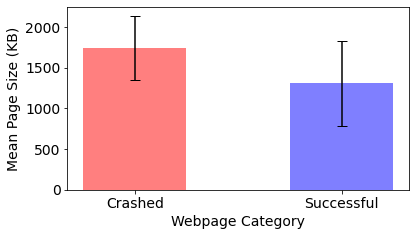

In [152]:
plt.rcParams.update({'font.size': 14})

usable = {'os':['Crashed','Successful'],
        'plt':[1741.3, 1308.5],
         'ci':[397.7, 523.8]}

usable = pd.DataFrame(usable)
new_colors = ['red','blue']

plt.figure(figsize=(6,3.5))
plt.bar(usable['os'],usable['plt'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)
plt.xlabel('Webpage Category')
plt.ylabel('Mean Page Size (KB)')
plt.tight_layout()
plt.savefig('figs/plt_gsi_crashed_succ_pagesize.png', dpi=400)
plt.show()

### Analysis of Web pages that loaded successfully

`Case-1: Consider "all" pages loaded successfully between treatment and control groups`

Limitation: Due to differing crash rates, we have data on less successfully loaded pages in GSI, resulting in imbalance across groups

In [153]:
# remove all crashed pages from df_plt for subsequent analysis
print("size of original df: ", len(df_plt))
df_plt = df_plt.loc[(df_plt['PLT'] != 0)]
df_plt['PLT'] = df_plt['PLT'].astype(float)
print("size of df with successful loads only: ", len(df_plt))

size of original df:  588
size of df with successful loads only:  549


In [156]:
print("Non-Go PLT mean=", df_plt.loc[df_plt['os'] == 0]["PLT"].mean(), "std=", np.sqrt(df_plt.loc[df_plt['os'] == 0]["PLT"].std()))
print("Go PLT     mean=", df_plt.loc[df_plt['os'] == 1]["PLT"].mean(), "std=", np.sqrt(df_plt.loc[df_plt['os'] == 1]["PLT"].std()))
print("% Reduction in PLT over non-Go=", (df_plt.loc[df_plt['os'] == 0]["PLT"].mean() - df_plt.loc[df_plt['os'] == 1]["PLT"].mean()) * 100.0 / df_plt.loc[df_plt['os'] == 0]["PLT"].mean() )


Non-Go PLT mean= 23256.343410852704 std= 151.027242167575
Go PLT     mean= 15637.774953642616 std= 117.62638353488117
% Reduction in PLT over non-Go= 32.75909855052639


`Case-2: Consider only "common" pages between treatment and control groups that were loaded successfully`

Limitation: This is likely to be an underestimate of the causal effect.

In [158]:
# find crashes within each MP level (no mp, low mp, high mp)
# drop corresponding URLs in each OS (0 and 1)

df_common = df_orig.copy(deep=True)

to_drop = df_common.loc[(df_common['os']==0) & (df_common['mp_high']==1) & (df_common['PLT']==0)]
list_url = to_drop['URL'].to_list()

for i in list_url:
    drop_index = (df_common.loc[(df_plt['URL'] == i) & (df_common['os']==0) & (df_common['mp_high']==1)]).index
    df_common.drop(drop_index, axis=0, inplace=True)
    drop = df_common.loc[(df_plt['URL'] == i) & (df_common['os']==1) & (df_common['mp_high']==1)]
    df_common.drop(drop.index, axis=0, inplace=True)

len(df_common)
    
to_drop = df_common.loc[(df_common['os']==0) & (df_common['mp_low']==1) & (df_common['PLT']==0)]
list_url = to_drop['URL'].to_list()

for i in list_url:
    drop = df_common.loc[(df_plt['URL'] == i) & (df_common['os']==0) & (df_common['mp_low']==1)]
    df_common.drop(drop.index, axis=0, inplace=True)
    drop = df_common.loc[(df_plt['URL'] == i) & (df_common['os']==1) & (df_common['mp_low']==1)]
    df_common.drop(drop.index, axis=0, inplace=True)
    
len(df_common)

555

In [160]:
s_list = []
plt_list = []

# mean PLT w/ Go
temp1 = df_common.loc[(df_common['os'] == 1)]["PLT"]
temp1.reset_index(drop=True, inplace=True)
t1_mean = temp1.mean()

# mean PLT w/ GSI
temp2 = df_common.loc[(df_common['os'] == 0)]["PLT"]
temp2.reset_index(drop=True, inplace=True)
t2_mean = temp2.mean()

print(t1_mean)
plt_list.append(t1_mean/1000)
print(stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1)))
print(t2_mean)
plt_list.append(t2_mean/1000)
print(stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2)))
print(t2_mean-t1_mean)

s1=(t1_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1))[0]
s_list.append(s1/1000)
print(s1)
s2=(t2_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2))[0]
s_list.append(s2/1000)
print(s2)

print(plt_list)
print("% Reduction in PLT over non-Go:", (np.mean(temp2) - np.mean(temp1)) * 100.0 / (np.mean(temp2)))

13793.170169693492
(12347.57565184092, 15238.764687546065)
20408.627891156455
(17815.450337220827, 23001.805445092083)
6615.457721462963
1445.5945178525726
2593.1775539356277
[13.793170169693493, 20.408627891156456]
% Reduction in PLT over non-Go: 32.41500485355803


## `Figure 6b`

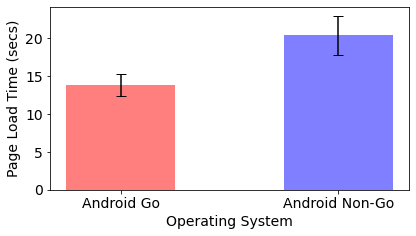

In [161]:
plt.rcParams.update({'font.size': 14})

usable = {'os':['Android Go','Android Non-Go'],
        'plt':plt_list,
        'ci':s_list}

usable = pd.DataFrame(usable) 
new_colors = ['red','blue']

plt.figure(figsize=(6,3.5))
plt.bar(usable['os'],usable['plt'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)
plt.xlabel('Operating System')
plt.ylabel('Page Load Time (secs)')
plt.tight_layout()
plt.savefig('figs/plt_go_vs_gsi_common.png', dpi=400)
plt.show()

In [162]:
len(df_plt)

549

In [163]:
s_list = []
plt_list = []

# mean PLT w/ Go
temp1 = df_plt.loc[(df_plt['os'] == 1)]["PLT"]
temp1.reset_index(drop=True, inplace=True)
t1_mean = temp1.mean()

# mean PLT w/ GSI
temp2 = df_plt.loc[(df_plt['os'] == 0)]["PLT"]
temp2.reset_index(drop=True, inplace=True)
t2_mean = temp2.mean()

print(t1_mean)
plt_list.append(t1_mean/1000)
print(stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1)))
print(t2_mean)
plt_list.append(t2_mean/1000)
print(stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2)))
print(t2_mean-t1_mean)

s1=(t1_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1))[0]
s_list.append(s1/1000)
print(s1)
s2=(t2_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2))[0]
s_list.append(s2/1000)
print(s2)

print(plt_list)

15637.774953642616
(14048.089918590009, 17227.459988695224)
23256.343410852704
(20473.11517225827, 26039.571649447138)
7618.568457210087
1589.6850350526074
2783.2282385944345
[15.637774953642616, 23.256343410852704]


## Mean PLT plots consider "All pages"
- Not included in the paper

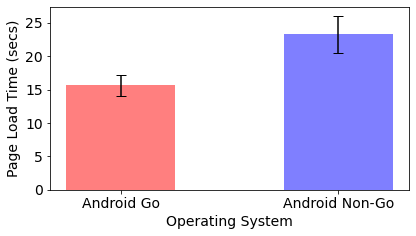

In [164]:
usable = {'os':['Android Go','Android Non-Go'],
        'plt':plt_list,
        'ci':s_list}

usable = pd.DataFrame(usable)
new_colors = ['red','blue']

plt.figure(figsize=(6,3.5))
plt.bar(usable['os'],usable['plt'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)
plt.xlabel('Operating System')
plt.ylabel('Page Load Time (secs)')
plt.tight_layout()
plt.savefig('figs/plt_go_vs_gsi.png', dpi=400)
plt.show()

In [165]:
usable

,os,plt,ci
0,Android Go,15.637775,1.589685
1,Android Non-Go,23.256343,2.783228


## `Figure 7`

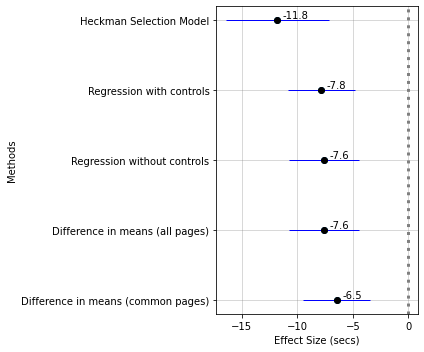

In [169]:
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 10})

x= [-6461.6/1000, -7618/1000, -7618/1000, -7843/1000, -11793/1000]
y= ['Difference in means (common pages)', 'Difference in means (all pages)', 'Regression without controls', 'Regression with controls', 'Heckman Selection Model']

# Define Error
x_error = [3041/1000, 3124/1000, 3124/1000, 3014/1000, 4665/1000]
plt.scatter(x,y)
plt.errorbar(x, y, xerr = x_error,fmt='o',ecolor = 'blue',color='black',linewidth=1)
plt.axvline(x=0, ymin=0, ymax=1, color='grey', linestyle='dotted', linewidth=3)

for i,j in enumerate(np.array([-6.5,-7.6,-7.6,-7.8,-11.8])):
    plt.annotate(j, xy=(x[i]+0.5,y[i]), ha='left', va='bottom')

plt.xlabel('Effect Size (secs)')
plt.ylabel('Methods')
plt.grid(visible=True, which='major', color='gray', alpha=0.3, lw=1)
plt.tight_layout()
plt.savefig('figs/hline_methods_plt.png', dpi=400)
plt.show()

## OLS Regression Analysis
- Finding the causal effect of OS
- We evaluate 2 OLS regression models
    * RM-1: We regress 'os' on PLT without any controls
    * RM-2: We regress 'os' on PLT with controls for both number of Web objects, their sizes, and the number of DOM elements

__`Regression Model - 1:`__ $Y = \beta + \beta_1 \times os$

_Model limitation: Due to differing crash rates between Go and non-Go, the Web pages loaded successfully are different across treatment (Android Go) and control groups (Android non-Go). This imbalance can impact the accuracy of results._

In [171]:
## specification-1: no controls
formula = 'PLT ~ os'
model_1 = smf.ols(formula, data=df_plt)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    PLT   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     22.95
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           2.15e-06
Time:                        23:56:46   Log-Likelihood:                -6175.1
No. Observations:                 549   AIC:                         1.235e+04
Df Residuals:                     547   BIC:                         1.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.326e+04   1157.933     20.084      0.0

__`Regression Model - 2:`__ $Y = \beta + \beta_1 \times os + \beta_2 \times images\_kb + \beta_3 \times scripts\_kb + \beta_4 \times css_kb + \beta_5 \times iframes\_kb + \beta_6 \times font\_kb + \beta_7 \times num\_images + \beta_8 \times num\_scripts + \beta_9 \times num\_css + \beta_{10} \times num\_iframes + \beta_{11} \times requests\_font + \beta_{12} \times dom\_elements$

_Model limitation: Due to differing crash rates between Go and non-Go, the Web pages loaded successfully are different across treatment (Android Go) and control groups (Android non-Go). This imbalance can impact the accuracy of results. Controlling for Web page features can reduce bias as well as improve precision especially if crashes are randomly sampled over the treatment and control groups. Unfortunately, crashes are non-randomly sampled and thus, OLS regression with controls is insufficient for recovering the causal effect._

In [172]:
## specification-2: with controls
formula = 'PLT ~ os + images_kb + scripts_kb + css_kb + iframes_kb + fonts_kb + num_images + num_scripts + num_css + num_iframes + requests_font + dom_elements'
model_2 = smf.ols(formula, data=df_plt)
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PLT   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     6.550
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           5.62e-11
Time:                        23:58:24   Log-Likelihood:                -6148.9
No. Observations:                 549   AIC:                         1.232e+04
Df Residuals:                     536   BIC:                         1.238e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.624e+04   1679.312      9.669

## <font color=blue>C. Feature Selection Using Random Forest</font>
- `Method: Random Forest based Feature Importances`
- `Note: We use 100,000 trees in our random forest evaluation so computing feature importances takes time.`

## Web page features that matter for both Android Go and non-Go

In [89]:
from sklearn.ensemble import RandomForestRegressor

formula = ['os', 'images_kb', 'scripts_kb', 'css_kb', 'iframes_kb', 'fonts_kb',\
            'num_images', 'num_scripts', 'num_css', 'num_iframes', 'requests_font', 'dom_elements']

df_rf = df_plt.loc[df_plt['PLT'] != 0]
exog = df_rf[formula]
endog = df_rf[['PLT']]

output = []
num_features = [12]

# Note: we used n_estimators=100000 in the paper, which takes substantial time to run.
for i in num_features:
    regr_overall = RandomForestRegressor(max_features="sqrt",random_state=0,oob_score=True,n_estimators=100000)
    random_forest_model_overall = regr_overall.fit(exog, endog['PLT'])
    results = random_forest_model_overall.predict(exog)

    print("R2 of the model (training set) :", regr_overall.score(exog,endog))
    print("Total samples used in training :", len(regr_overall.oob_prediction_))
    print("Feature importances            :", regr_overall.feature_importances_)
    
    sorted_idx = regr_overall.feature_importances_.argsort()
    feature_names = np.array(formula)

R2 of the model (training set) : 0.4252310461693881
Total samples used in training : 549
Feature importances            : [0.19124558 0.07466443 0.08301104 0.06812346 0.07507368 0.05016289
 0.09635792 0.08230358 0.04810206 0.09102037 0.04418885 0.09574612]


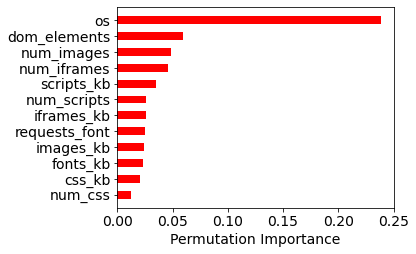

In [90]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(regr_overall, exog, endog)
plt.rcParams.update({'figure.figsize': (6, 3.5)})
plt.rcParams.update({'font.size': 14})
width=0.5
fig, ax = plt.subplots(figsize=(6,3.5))

sorted_idx = perm_importance.importances_mean.argsort()
ax.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx], width, color='r')
plt.tight_layout()
plt.xlabel("Permutation Importance")
plt.show()
fig.savefig('figs/permutation_features_randomforest_overall.png', dpi=400)

### Features that are most predictive of PLT under Android Go

In [91]:
from sklearn.ensemble import RandomForestRegressor

formula = ['images_kb', 'scripts_kb', 'css_kb', 'iframes_kb', 'fonts_kb',\
            'num_images', 'num_scripts', 'num_css', 'num_iframes', 'requests_font', 'dom_elements']

df_rf_go = df_plt.loc[df_plt['PLT'] != 0]
df_go = df_rf_go.loc[df_rf_go['os']==1]

exog = df_go[formula]
endog = df_go[['PLT']]

output = []
num_features = [11]

# Note: we used n_estimators=100000 in the paper, which takes substantial time to run.
for i in num_features:
    regr_go = RandomForestRegressor(max_features="sqrt",random_state=0,oob_score=True,n_estimators=100000)
    random_forest_model_go = regr_go.fit(exog, endog['PLT'])
    results = random_forest_model_go.predict(exog)
    
    print("R2 of the model (training set) :", regr_go.score(exog,endog))
    print("Total samples used in training :", len(regr_go.oob_prediction_))
    print("Feature importances            :", regr_go.feature_importances_)
    
    sorted_idx = regr_go.feature_importances_.argsort()
    feature_names = np.array(formula)

R2 of the model (training set) : 0.47946363019646077
Total samples used in training : 291
Feature importances            : [0.08477943 0.09056446 0.07682963 0.1151645  0.04880704 0.14550059
 0.09289205 0.04413182 0.15234934 0.04736978 0.10161135]


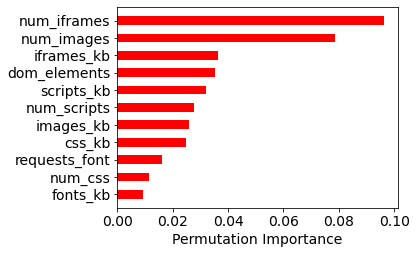

In [92]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(regr_go, exog, endog)
plt.rcParams.update({'figure.figsize': (6, 3.5)})
plt.rcParams.update({'font.size': 14})
width=0.5
fig, ax = plt.subplots(figsize=(6,3.5))

sorted_idx = perm_importance.importances_mean.argsort()
ax.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx], width, color='r')
plt.tight_layout()
plt.xlabel("Permutation Importance")
plt.show()
fig.savefig('figs/permutation_features_randomforest_go.png', dpi=400)

### Features that are most predictive of PLT under Android non-Go

In [93]:
from sklearn.ensemble import RandomForestRegressor

formula = ['images_kb', 'scripts_kb', 'css_kb', 'iframes_kb', 'fonts_kb',\
            'num_images', 'num_scripts', 'num_css', 'num_iframes', 'requests_font', 'dom_elements']

df_rf_nongo = df_plt.loc[df_plt['PLT'] != 0]
df_nongo = df_rf_nongo.loc[df_rf_nongo['os']==0]

exog = df_nongo[formula]
endog = df_nongo[['PLT']]

output = []
num_features = [11]

# Note: we used n_estimators=100000 in the paper, which takes substantial time to run.
for i in num_features:
    regr_nongo = RandomForestRegressor(max_features="sqrt",random_state=0,oob_score=True,n_estimators=100000)
    random_forest_model_nongo = regr_nongo.fit(exog, endog['PLT'])
    results = random_forest_model_nongo.predict(exog)
    
    print("R2 of the model (training set) :", regr_nongo.score(exog,endog))
    print("Total samples used in training :", len(regr_nongo.oob_prediction_))
    print("Feature importances            :", regr_nongo.feature_importances_)
    
    sorted_idx = regr_nongo.feature_importances_.argsort()
    feature_names = np.array(formula)

R2 of the model (training set) : 0.36738421632045526
Total samples used in training : 258
Feature importances            : [0.10121808 0.10632404 0.08427789 0.08637303 0.07495566 0.10681574
 0.10333613 0.06620394 0.09066712 0.05759645 0.12223191]


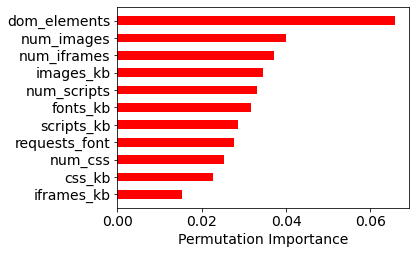

In [94]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(regr_nongo, exog, endog)
plt.rcParams.update({'figure.figsize': (6, 3.5)})
plt.rcParams.update({'font.size': 14})
width=0.5
fig, ax = plt.subplots(figsize=(6,3.5))

sorted_idx = perm_importance.importances_mean.argsort()
ax.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx], width, color='r')
plt.tight_layout()
plt.xlabel("Permutation Importance")
plt.show()
fig.savefig('figs/permutation_features_randomforest_nongo.png', dpi=400)

## <font color=blue>D. Heterogeneous Treatment Effects Analysis</font>
### `Figure 9`
- Impact of OS across different memory pressure (MP) states

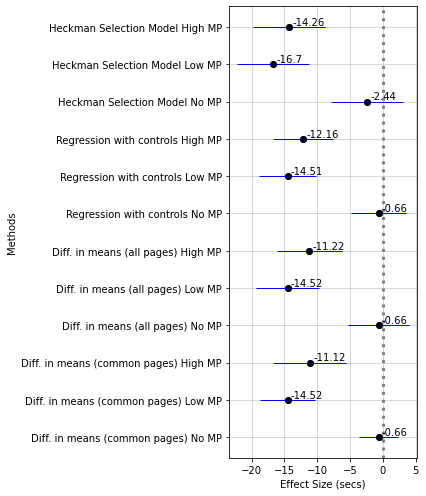

In [176]:
plt.figure(figsize=(6,7))
plt.rcParams.update({'font.size': 10})

x = [-662/1000, -14520/1000, -11123/1000,\
     -662/1000, -14520/1000, -11220/1000,\
     -662/1000, -14510/1000, -12156/1000,\
     -2441/1000, -16700/1000, -14260/1000]
y = ['Diff. in means (common pages) No MP','Diff. in means (common pages) Low MP','Diff. in means (common pages) High MP',\
    'Diff. in means (all pages) No MP','Diff. in means (all pages) Low MP','Diff. in means (all pages) High MP',\
    'Regression with controls No MP','Regression with controls Low MP','Regression with controls High MP',\
    'Heckman Selection Model No MP','Heckman Selection Model Low MP','Heckman Selection Model High MP']

# Define Error
x_error = [3041/1000, 4132/1000, 5576/1000,\
           4600/1000, 4780/1000, 4980/1000,\
           4171/1000, 4370/1000, 4530/1000,\
           5451/1000, 5470/1000, 5510/1000]

plt.scatter(x,y)
plt.errorbar(x, y, xerr = x_error,fmt='o',ecolor = 'blue',color='black',linewidth=1)
plt.axvline(x=0, ymin=0, ymax=1, color='grey', linestyle='dotted', linewidth=3)

for i,j in enumerate(np.array([-660/1000, -14520/1000, -11120/1000,\
     -660/1000, -14520/1000, -11220/1000,\
     -660/1000, -14510/1000, -12160/1000,\
     -2440/1000, -16700/1000, -14260/1000])):
    plt.annotate(j, xy=(x[i]+0.5,y[i]), ha='left', va='bottom')

plt.xlabel('Effect Size (secs)')
plt.ylabel('Methods')
plt.grid(visible=True, which='major', color='gray', alpha=0.3, lw=1)
plt.tight_layout()
plt.savefig('figs/hline_methods_plt_mp.png', dpi=400)
plt.show()

In [178]:
# Clean data as done earliar
data = pd.read_csv("imc22_dataset.csv")

# Step-1
drop_index = data.loc[data["URL"] == "https://www.alipay.com"].index
data.drop(drop_index, axis=0, inplace=True)
drop_index = data.loc[data["URL"] == "https://www.jd.com"].index
data.drop(drop_index, axis=0, inplace=True)
print("N (observations) =",data.count()[1])

# Step-2
## if PLT == E or 0, set crash=1 otherwise 0
data['crash'] = np.where((data['PLT']=='E') | (data['PLT']=='0'), 1, 0)

## if PLT == E, change to 0
data['PLT'] = data['PLT'].replace('E',0)

## convert to float
data['PLT'] = data['PLT'].astype(float)

N (observations) = 588


In [179]:
# Let's make sure the data frame has no crashed pages in it
df_plt = df_plt.loc[(df_plt['PLT'] != 0)]
len(df_plt)

549

### Difference in Means (All Pages)

In [205]:
plt_list = []

temp1 = df_plt.loc[(df_plt['os'] == 1) & (df_plt['mp_no'] == 1)]["PLT"]
temp1.reset_index(drop=True, inplace=True)
t1_mean = temp1.mean()
plt_list.append(t1_mean/1000)

temp2 = df_plt.loc[(df_plt['os'] == 0) & (df_plt['mp_no'] == 1)]["PLT"]
temp2.reset_index(drop=True, inplace=True)
t2_mean = temp2.mean()
plt_list.append(t2_mean/1000)

temp3 = df_plt.loc[(df_plt['os'] == 1) & (df_plt['mp_low'] == 1)]["PLT"]
temp3.reset_index(drop=True, inplace=True)
t3_mean = temp3.mean()
plt_list.append(t3_mean/1000)

temp4 = df_plt.loc[(df_plt['os'] == 0) & (df_plt['mp_low'] == 1)]["PLT"]
temp4.reset_index(drop=True, inplace=True)
t4_mean = temp4.mean()
plt_list.append(t4_mean/1000)

temp5 = df_plt.loc[(df_plt['os'] == 1) & (df_plt['mp_high'] == 1)]["PLT"]
temp5.reset_index(drop=True, inplace=True)
t5_mean = temp5.mean()
plt_list.append(t5_mean/1000)

temp6 = df_plt.loc[(df_plt['os'] == 0) & (df_plt['mp_high'] == 1)]["PLT"]
temp6.reset_index(drop=True, inplace=True)
t6_mean = temp6.mean()
plt_list.append(t6_mean/1000)

# Finding 1-sided CI values
s_list = []
s1=(t1_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1))[0]
s_list.append(s1/1000)
s2=(t2_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2))[0]
s_list.append(s2/1000)

#s12 = (t1_mean-t2_mean) - stats.norm.interval(alpha=0.95, loc=np.mean((temp1-temp2)), scale=stats.sem((temp1-temp2)))[0]

s12 = (t1_mean-t2_mean) - stats.norm.interval(alpha=0.95, loc=np.nanmean((temp1-temp2)), scale=stats.sem((temp1-temp2), nan_policy='omit'))[0]


s3=(t3_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp3), scale=stats.sem(temp3))[0]
s_list.append(s3/1000)
s4=(t4_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp4), scale=stats.sem(temp4))[0]
s_list.append(s4/1000)

s34 = (t3_mean-t4_mean) - stats.norm.interval(alpha=0.95, loc=np.nanmean((temp3-temp4)), scale=stats.sem((temp3-temp4), nan_policy='omit'))[0]

s5=(t5_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp5), scale=stats.sem(temp5))[0]
s_list.append(s5/1000)
s6=(t6_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp6), scale=stats.sem(temp6))[0]
s_list.append(s6/1000)

s56 = (t5_mean-t6_mean) - stats.norm.interval(alpha=0.95, loc=np.nanmean((temp5-temp6)), scale=stats.sem((temp5-temp6), nan_policy='omit'))[0]

print("[Go, No MP]      :", round(t1_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1)), "-- One-sided:", round(s1))
print("[Non-Go, No MP]  :", round(t2_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2)), "-- One-sided:", round(s2))
print("[diff in means]  :", round(t1_mean-t2_mean))
print("% Reduction      :", round( (t2_mean-t1_mean)*100.0/t2_mean ,1), "%\n")
print("[diff in mean CI]:", "-- One-sided:", s12)

print("\n[Go, Low MP]     :", round(t3_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp3), scale=stats.sem(temp3)), "-- One-sided:", round(s3))
print("[Non-Go, Low MP] :", round(t4_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp4), scale=stats.sem(temp4)), "-- One-sided:", round(s4))
print("[diff in means]  :", round(t3_mean-t4_mean))
print("% Reduction      :", round( (t4_mean-t3_mean)*100.0/t4_mean ,1), "%\n")
print("[diff in mean CI]:", "-- One-sided:", s34)

print("\n[Go, High MP]    :", round(t5_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp5), scale=stats.sem(temp5)), "-- One-sided:", round(s5))
print("[Non-Go, High MP]:", round(t6_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp6), scale=stats.sem(temp6)), "-- One-sided:", round(s6))
print("[diff in means]  :", round(t5_mean-t6_mean))
print("% Reduction      :", round( (t6_mean-t5_mean)*100.0/t6_mean ,1), "%\n")
print("[diff in mean CI]:", "-- One-sided:", round(s56))

[Go, No MP]      : 10209 -- CI: (8721.979195147524, 11695.735090566766) -- One-sided: 1487
[Non-Go, No MP]  : 10871 -- CI: (9299.112226814763, 12442.157160940333) -- One-sided: 1572
[diff in means]  : -662
% Reduction      : 6.1 %

[diff in mean CI]: -- One-sided: 141.69564076838492

[Go, Low MP]     : 11260 -- CI: (9763.345297084912, 12757.345424564568) -- One-sided: 1497
[Non-Go, Low MP] : 25780 -- CI: (21228.11918600316, 30331.745930275916) -- One-sided: 4552
[diff in means]  : -14520
% Reduction      : 56.3 %

[diff in mean CI]: -- One-sided: 4132.211981964454

[Go, High MP]    : 25603 -- CI: (22028.4058551952, 29177.24021792979) -- One-sided: 3574
[Non-Go, High MP]: 36726 -- CI: (30240.03948495898, 43212.39835287888) -- One-sided: 6486
[diff in means]  : -11123
% Reduction      : 30.3 %

[diff in mean CI]: -- One-sided: 5576


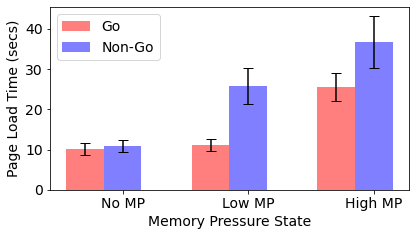

In [182]:
plt.rcParams.update({'font.size': 14})

usable = {'os':['(Go, No-MP)', '(Non-Go, No-MP)', '(Go, Low-MP)', '(Non-Go, Low-MP)', '(Go, High-MP)', '(Non-Go, High-MP)'],
        'plt': plt_list,
         'ci': s_list}

usable1 = {'os':['(Go, No-MP)', '(Go, Low-MP)', '(Go, High-MP)'],
        'plt': [10.209, 11.178, 25.498],
         'ci': [1.487, 1.490, 3.543]}

usable2 = {'os':['(Non-Go, No-MP)', '(Non-Go, Low-MP)', '(Non-Go, High-MP)'],
        'plt': [10.871, 25.780, 36.726],
         'ci': [1.572, 4.552, 6.486]}

usable = pd.DataFrame(usable)
new_colors2 = ['blue','blue','blue']
new_colors1 = ['red','red','red']

barWidth = 0.3
r1 = np.arange(len(usable1))
r2 = [x + barWidth for x in r1]
    
plt.figure(figsize=(6,3.5))
plt.bar(r1, usable1['plt'], width = barWidth, yerr=usable1['ci'],color=new_colors1,alpha=0.5, align='center',capsize=5,label='Go')
plt.bar(r2, usable2['plt'], width = barWidth, yerr=usable2['ci'],color=new_colors2,alpha=0.5, align='center',capsize=5,label='Non-Go')
plt.xticks([r + barWidth for r in range(len(usable1))], ['No MP', 'Low MP', 'High MP'])
plt.legend()
plt.xlabel('Memory Pressure State')
plt.ylabel('Page Load Time (secs)')
plt.tight_layout()
plt.savefig('figs/plt_mp.png', dpi=400)
plt.show()

### Difference in Means across MP States (Common Pages)

In [183]:
# find crashes within each MP level (no mp, low mp, high mp)
# drop corresponding URLs in each OS (0 and 1)

df_common = df_orig.copy(deep=True)
to_drop = df_common.loc[(df_common['os']==0) & (df_common['mp_high']==1) & (df_common['PLT']==0)]
list_url = to_drop['URL'].to_list()

for i in list_url:
    drop_index = (df_common.loc[(df_plt['URL'] == i) & (df_common['os']==0) & (df_common['mp_high']==1)]).index
    df_common.drop(drop_index, axis=0, inplace=True)
    drop = df_common.loc[(df_plt['URL'] == i) & (df_common['os']==1) & (df_common['mp_high']==1)]
    df_common.drop(drop.index, axis=0, inplace=True)

len(df_common)
    
to_drop = df_common.loc[(df_common['os']==0) & (df_common['mp_low']==1) & (df_common['PLT']==0)]
list_url = to_drop['URL'].to_list()

for i in list_url:
    drop = df_common.loc[(df_plt['URL'] == i) & (df_common['os']==0) & (df_common['mp_low']==1)]
    df_common.drop(drop.index, axis=0, inplace=True)
    drop = df_common.loc[(df_plt['URL'] == i) & (df_common['os']==1) & (df_common['mp_low']==1)]
    df_common.drop(drop.index, axis=0, inplace=True)
    
len(df_common)

555

In [184]:
plt_list = []

temp1 = df_common.loc[(df_common['os'] == 1) & (df_common['mp_no'] == 1)]["PLT"]
temp1.reset_index(drop=True, inplace=True)
t1_mean = temp1.mean()
plt_list.append(t1_mean/1000)

temp2 = df_common.loc[(df_common['os'] == 0) & (df_common['mp_no'] == 1)]["PLT"]
temp2.reset_index(drop=True, inplace=True)
t2_mean = temp2.mean()
plt_list.append(t2_mean/1000)

temp3 = df_common.loc[(df_common['os'] == 1) & (df_common['mp_low'] == 1)]["PLT"]
temp3.reset_index(drop=True, inplace=True)
t3_mean = temp3.mean()
plt_list.append(t3_mean/1000)

temp4 = df_common.loc[(df_common['os'] == 0) & (df_common['mp_low'] == 1)]["PLT"]
temp4.reset_index(drop=True, inplace=True)
t4_mean = temp4.mean()
plt_list.append(t4_mean/1000)

temp5 = df_common.loc[(df_common['os'] == 1) & (df_common['mp_high'] == 1)]["PLT"]
temp5.reset_index(drop=True, inplace=True)
t5_mean = temp5.mean()
plt_list.append(t5_mean/1000)

temp6 = df_common.loc[(df_common['os'] == 0) & (df_common['mp_high'] == 1)]["PLT"]
temp6.reset_index(drop=True, inplace=True)
t6_mean = temp6.mean()
plt_list.append(t6_mean/1000)

# Finding 1-sided CI values
s_list = []
s1=(t1_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1))[0]
s_list.append(s1/1000)
s2=(t2_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2))[0]
s_list.append(s2/1000)

s12 = (t1_mean-t2_mean) - stats.norm.interval(alpha=0.95, loc=np.mean((temp1-temp2)), scale=stats.sem((temp1-temp2)))[0]

s3=(t3_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp3), scale=stats.sem(temp3))[0]
s_list.append(s3/1000)
s4=(t4_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp4), scale=stats.sem(temp4))[0]
s_list.append(s4/1000)

s34 = (t3_mean-t4_mean) - stats.norm.interval(alpha=0.95, loc=np.nanmean((temp3-temp4)), scale=stats.sem((temp3-temp4), nan_policy='omit'))[0]

s5=(t5_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp5), scale=stats.sem(temp5))[0]
s_list.append(s5/1000)
s6=(t6_mean)-stats.norm.interval(alpha=0.95, loc=np.mean(temp6), scale=stats.sem(temp6))[0]
s_list.append(s6/1000)

s56 = (t5_mean-t6_mean) - stats.norm.interval(alpha=0.95, loc=np.nanmean((temp5-temp6)), scale=stats.sem((temp5-temp6), nan_policy='omit'))[0]

print("[Go, No MP]      :", round(t1_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp1), scale=stats.sem(temp1)), "-- One-sided:", round(s1))
print("[Non-Go, No MP]  :", round(t2_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp2), scale=stats.sem(temp2)), "-- One-sided:", round(s2))
print("[diff in means]  :", round(t1_mean-t2_mean))
print("[diff in mean CI]:", "-- One-sided:", round(s12))

print("\n[Go, Low MP]     :", round(t3_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp3), scale=stats.sem(temp3)), "-- One-sided:", round(s3))
print("[Non-Go, Low MP] :", round(t4_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp4), scale=stats.sem(temp4)), "-- One-sided:", round(s4))
print("[diff in means]  :", round(t3_mean-t4_mean))
print("[diff in mean CI]:", "-- One-sided:", s34)

print("\n[Go, High MP]    :", round(t5_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp5), scale=stats.sem(temp5)), "-- One-sided:", round(s5))
print("[Non-Go, High MP]:", round(t6_mean), "-- CI:", stats.norm.interval(alpha=0.95, loc=np.mean(temp6), scale=stats.sem(temp6)), "-- One-sided:", round(s6))
print("[diff in means]  :", round(t5_mean-t6_mean))
print("[diff in mean CI]:", "-- One-sided:", round(s56))



[Go, No MP]      : 10209 -- CI: (8721.979195147524, 11695.735090566766) -- One-sided: 1487
[Non-Go, No MP]  : 10871 -- CI: (9299.112226814763, 12442.157160940333) -- One-sided: 1572
[diff in means]  : -662
[diff in mean CI]: -- One-sided: 142

[Go, Low MP]     : 10607 -- CI: (8995.406538615967, 12218.713001613913) -- One-sided: 1612
[Non-Go, Low MP] : 22623 -- CI: (18291.820465118297, 26954.591779779665) -- One-sided: 4331
[diff in means]  : -12016
[diff in mean CI]: -- One-sided: 4618.311602448355

[Go, High MP]    : 22062 -- CI: (18479.506102226762, 25645.104800141657) -- One-sided: 3583
[Non-Go, High MP]: 27732 -- CI: (21919.51340582014, 33544.572308465584) -- One-sided: 5813
[diff in means]  : -5670
[diff in mean CI]: -- One-sided: 8851


## `Figure 8c`

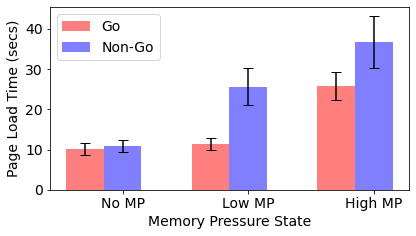

In [185]:
usable = {'os':['(Go, No-MP)', '(Non-Go, No-MP)', '(Go, Low-MP)', '(Non-Go, Low-MP)', '(Go, High-MP)', '(Non-Go, High-MP)'],
        'plt': plt_list,
         'ci': s_list}

usable1 = {'os':['(Go, No-MP)', '(Go, Low-MP)', '(Go, High-MP)'],
        'plt': [10.209, 11.260, 25.780],
         'ci': [1.487, 1.497, 3.574]}

usable2 = {'os':['(Non-Go, No-MP)', '(Non-Go, Low-MP)', '(Non-Go, High-MP)'],
        'plt': [10.871, 25.603, 36.726],
         'ci': [1.572, 4.552, 6.486]}

usable = pd.DataFrame(usable)
new_colors2 = ['blue','blue','blue']
new_colors1 = ['red','red','red']
barWidth = 0.3
r1 = np.arange(len(usable1))
r2 = [x + barWidth for x in r1]
    
plt.figure(figsize=(6,3.5))
plt.bar(r1, usable1['plt'], width = barWidth, yerr=usable1['ci'],color=new_colors1,alpha=0.5, align='center',capsize=5,label='Go')
plt.bar(r2, usable2['plt'], width = barWidth, yerr=usable2['ci'],color=new_colors2,alpha=0.5, align='center',capsize=5,label='Non-Go')
plt.xticks([r + barWidth for r in range(len(usable1))], ['No MP', 'Low MP', 'High MP'])
plt.legend()
plt.xlabel('Memory Pressure State')
plt.ylabel('Page Load Time (secs)')
plt.tight_layout()
plt.savefig('figs/plt_mp_common.png', dpi=400)
plt.show()

### Mean page size of successfully loaded and crashed pages

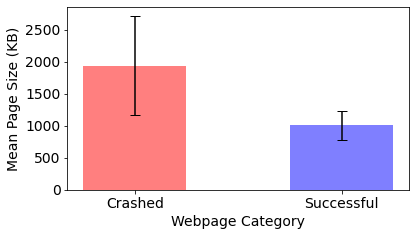

In [186]:
usable = {'os':['Crashed','Successful'],
        'plt':[1940.1, 1008.4],
         'ci':[779, 226]}

usable = pd.DataFrame(usable)
new_colors = ['red','blue']
    
plt.figure(figsize=(6,3.5))
plt.bar(usable['os'],usable['plt'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)
plt.xlabel('Webpage Category')
plt.ylabel('Mean Page Size (KB)')
plt.tight_layout()
plt.savefig('figs/plt_gsi_crashed_succ_pagesize.png', dpi=400)
plt.show()

## Impact of Device Characteristics

In [199]:
dv = pd.read_excel("android_devices.xlsx")
#dv.describe()

In [200]:
nokia_mean = dv["nokia"].mean()
nokiaplus_mean = dv["nokiaplus"].mean()

nokia_s1=(nokia_mean - stats.norm.interval(alpha=0.95, loc=np.mean(dv["nokia"]), scale=stats.sem(dv["nokia"]))[0])/1000
nokiaplus_s1=(nokiaplus_mean - stats.norm.interval(alpha=0.95, loc=np.mean(dv["nokiaplus"]), scale=stats.sem(dv["nokiaplus"]))[0])/1000

print("[Nokia-1]       :", nokia_mean/1000, "-- One-sided:", nokia_s1)
print("[Nokia-1 Plus]  :", nokiaplus_mean/1000, "-- One-sided:", nokiaplus_s1)
print("['Nokia-1' - 'Nokia-1 Plus']: Mean diff", (nokia_mean - nokiaplus_mean)/1000)
print("% Reduction     :", (nokia_mean - nokiaplus_mean) * 100.0 / nokia_mean, "%")

[Nokia-1]       : 9.660677777777794 -- One-sided: 3.3561696707329176
[Nokia-1 Plus]  : 8.099008333333332 -- One-sided: 2.692935775513297
['Nokia-1' - 'Nokia-1 Plus']: Mean diff 1.561669444444462
% Reduction     : 16.16521615115587 %


## `Figure 10b`

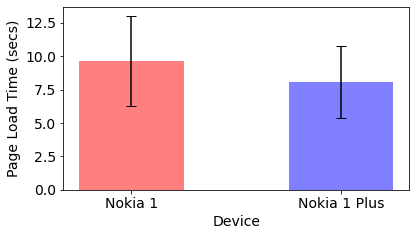

In [201]:
usable = {'dev':['Nokia 1','Nokia 1 Plus'],
        'plt':[9.67, 8.1],
         'ci':[3.36, 2.69]}

usable = pd.DataFrame(usable) 
new_colors = ['red','blue']
    
plt.figure(figsize=(6,3.5))
plt.bar(usable['dev'],usable['plt'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)

plt.xlabel('Device')
plt.ylabel('Page Load Time (secs)')
plt.tight_layout()
plt.savefig('figs/plt_across_devices.png', dpi=400)
plt.show()

## Analysis of Android Versions

In [202]:
dv = pd.read_excel("android_versions.xlsx")

In [203]:
nokia_mean = dv["android_ten"].mean()
nokiaplus_mean = dv["android_nine"].mean()

nokia_s1=(nokia_mean - stats.norm.interval(alpha=0.95, loc=np.mean(dv["android_ten"]), scale=stats.sem(dv["android_ten"]))[0])/1000
nokiaplus_s1=(nokiaplus_mean - stats.norm.interval(alpha=0.95, loc=np.mean(dv["android_nine"]), scale=stats.sem(dv["android_nine"]))[0])/1000

print("[Android 10] :", nokia_mean/1000, "-- One-sided:", nokia_s1)
print("[Android 9]  :", nokiaplus_mean/1000, "-- One-sided:", nokiaplus_s1)

[Android 10] : 9.923750724637697 -- One-sided: 3.4637894502740045
[Android 9]  : 9.88128695652174 -- One-sided: 3.4506268631548975


## `Figure 10a`

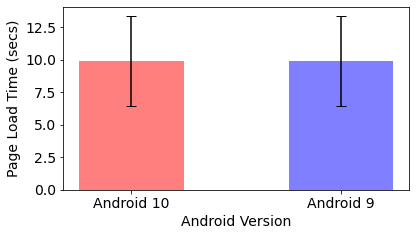

In [204]:
usable = {'dev':['Android 10','Android 9'],
        'plt':[9.92, 9.88],
         'ci':[3.46, 3.45]}

usable = pd.DataFrame(usable) 
new_colors = ['red','blue']
    
plt.figure(figsize=(6,3.5))
plt.bar(usable['dev'],usable['plt'],yerr=usable['ci'],color=new_colors,alpha=0.5, align='center',capsize=5,width=0.5)

plt.xlabel('Android Version')
plt.ylabel('Page Load Time (secs)')
plt.tight_layout()
plt.savefig('figs/plt_across_versions.png', dpi=400)
plt.show()